In [1]:
%load_ext autoreload
%autoreload 1
import os
from datetime import timedelta

import numpy as np
import obspy
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from obspy import UTCDateTime
from seispy.decon import RFTrace

from insight.util import TraceFile
from insight.util import trace_slice


# Load Data

In [2]:
DATA_DIR = "../data/"
CAT_FILE = "a_quality.parquet"
EVENT = "S1222a"
network, station, location = "XB", "ELYSE", "02"

img_zrt = np.asarray(Image.open("../img/S1222a_ZRT_0.25-2.0.png"))
img_prf = np.asarray(Image.open("../img/S1222a_PRF_0.25-1.0_g2.png"))

event = pd.read_parquet(os.path.join(DATA_DIR, CAT_FILE)).loc[EVENT]
trace_file = TraceFile(network, station, location, event.id)
st = obspy.read(os.path.join(DATA_DIR, "zne", str(trace_file)))
# event.est_p_arrival += timedelta(seconds=0.5)
event

id                              mqs2022isne
region name                Aeolis Northeast
time            2022-05-04T23:23:07.710516Z
quality                                   A
mqs_azimuth                           109.0
mqs_distance                      37.014014
p_arrival         2022-05-04 23:27:34+00:00
M_w                                     4.6
pp_arrival                              NaT
Name: S1222a, dtype: object

# Rotate to ZRT
Based on MQS Azimuth

In [3]:
st_zrt = st.copy().rotate(method="NE->RT", back_azimuth=event.mqs_azimuth)

# Detrend & Bandpass

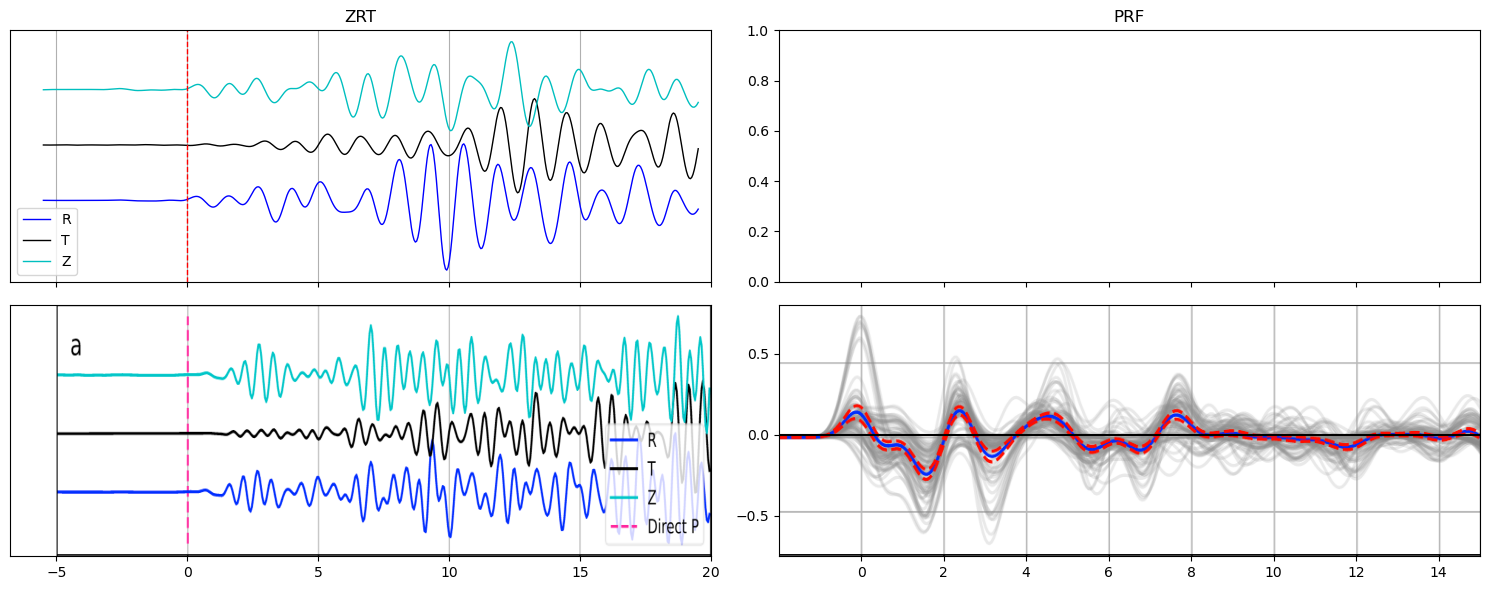

In [4]:
def trace_plot(axes: Axes, trace: obspy.Trace, start=10, end=40, t_offset=10, y_offset=0, plt_args={}):
    sliced = trace_slice(start, end, trace)
    times = sliced.times(type="relative")
    times -= t_offset
    data = sliced.data + y_offset
    axes.plot(times, data, **plt_args)


bandpass = {"freqmin": 0.25, "freqmax": 1.0, "corners": 4, "zerophase": True}
st_zrt_filtered = st_zrt.copy()
st_zrt_filtered.detrend()
st_zrt_filtered.filter(type="highpass", freq=0.01)
st_zrt_filtered.filter(type="bandpass", **bandpass)

fig, axs = plt.subplots(2, 2, figsize=(15, 6), dpi=100, sharex="col")
axs[0][0].set_title("ZRT")
axs[0][0].set_yticks([])
axs[0][1].set_title("PRF")
axs[1][0].imshow(img_zrt, extent=(-5, 20, -1, 1), aspect="auto")
axs[1][0].set_yticks([])
axs[1][1].imshow(img_prf, extent=(-2, 15, -.75, .8), aspect="auto")
axs[1][1].set_xticks(np.arange(0, 16, 2.0))
axs[1][1].set_yticks(np.arange(-.5, .6, .5))
axs[1][1].axhline(0, color="k")
ax = axs[0][0]
cols = "bkc"
plot_order = (1, 2, 0)
offset = 0.5
st_plottable = st_zrt_filtered.copy().normalize(global_max=True)
for i in range(len(plot_order)):
    tr = st_plottable.traces[plot_order[i]]
    trace_plot(ax, tr, start=5, end=30, t_offset=5.5, y_offset=-offset + i * offset,
               plt_args={"label": tr.meta.channel[-1], "color": cols[i], "linewidth": 1})
ax.grid(which="major")
ax.axvline(0, color="r", linewidth=1, linestyle="--")
ax.legend()
fig.tight_layout()

# Calculate PRFs

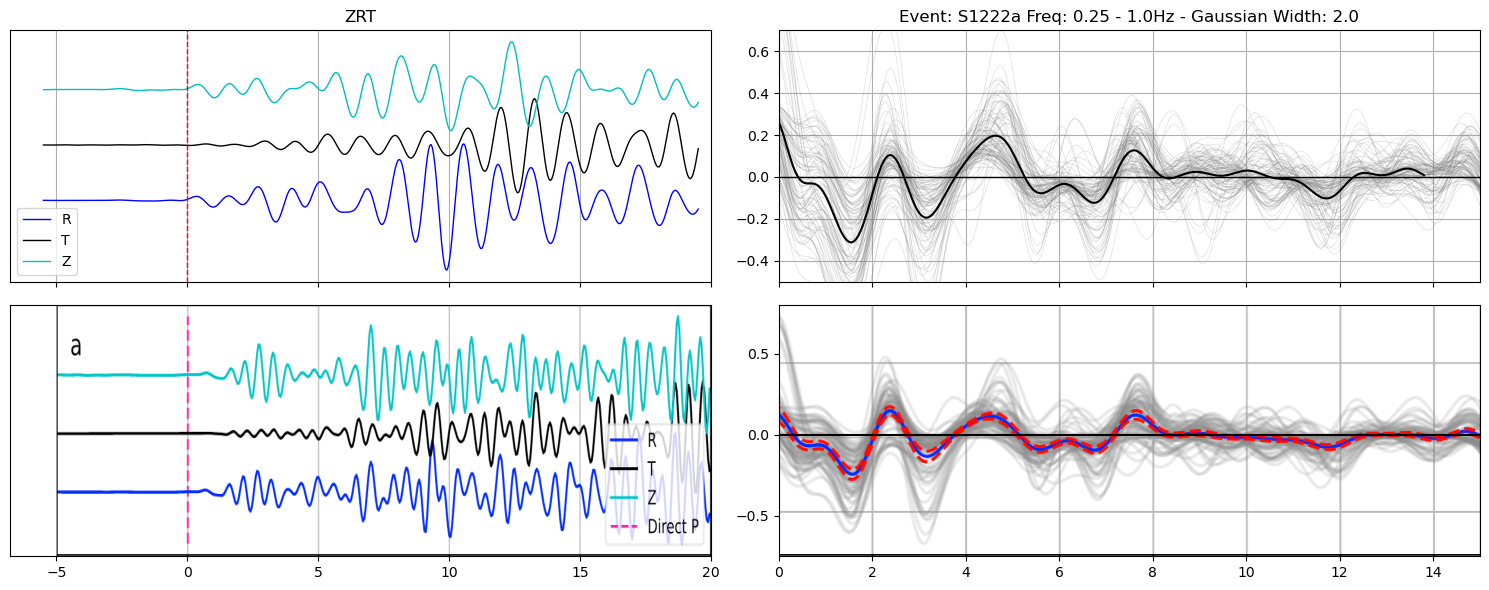

In [5]:
rf_start = 10

gauss_width = 2.0


def rf_plot(axes: Axes, rf: RFTrace, start=0, end=40, t_offset=10, invert_y=False):
    sliced = trace_slice(start, end, rf)
    times = sliced.times(type="relative")
    times -= t_offset
    data = sliced.data
    data *= -1 if invert_y else 1
    axes.plot(times, data, linewidth=0.5, color='k')
    axes.fill_between(times, data, where=(data > 0), color='red', alpha=.3)
    axes.fill_between(times, data, where=(data < 0), color='blue', alpha=.3)


ax = axs[0][1]
ax.cla()

series = []

for window in np.arange(15, 100 + rf_start + 1, 1):
    st_sliced = st_zrt_filtered.slice(UTCDateTime(event.p_arrival - timedelta(seconds=rf_start)),
                                      UTCDateTime(event.p_arrival + timedelta(seconds=int(window) + rf_start)))
    rf = RFTrace.deconvolute(
        utr=st_sliced.select(component="R")[0],  # utr = numerator (radial for PdS)
        wtr=st_sliced.select(component="Z")[0],  # wtr = denominator (vertical component for PdS)
        tshift=rf_start,  # tshift = Time until beginning of receiver function (s)
        f0=gauss_width,  # f0 = width of gaussian filter
        itmax=500,  # itmax = max # iterations
        minderr=0.0001,  # Min change in error required for stopping iterations
    )
    series.append(rf.data)
    times = rf.times(type="relative") - rf_start
    trace_plot(ax, rf, start=0, end=25, t_offset=rf_start,
               plt_args={"label": str(window), "color": ".5", "linewidth": 0.5, "alpha": 0.25})

# Calculate mean RF
shortest_rf = min([len(s) for s in series])
avg_rf = np.zeros(shortest_rf)
for i in series:
    avg_rf += i[:shortest_rf]
avg_rf /= len(series)
ax.axhline(0, color="k", linewidth=1)
ax.plot(times[:shortest_rf], avg_rf, color="k")

ax.set_xlim(0, 15)
ax.set_ylim(-.5, .7)
ax.grid(which="major")
# fig.suptitle(f"Event: {EVENT} Freq: {bandpass['freqmin']} - {bandpass['freqmax']}Hz - Gaussian Width: {gauss_width}")
ax.set_title(f"Event: {EVENT} Freq: {bandpass['freqmin']} - {bandpass['freqmax']}Hz - Gaussian Width: {gauss_width}")
fig